<a id="cuarto"></a>
## 4. Aplicación de una red neuronal en Localización
Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.  
Dentro de interiores se cuenta con señales RSSI (*fingerprint*) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.  

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos *Bluetooth* emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (*IndoorFingerprint.csv*) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (*C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI*) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos *Bluetooth* en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

<img src="https://i.imgur.com/Xheipaa.png" width="60%" height="20%" />

Grilla ejemplo de cómo funciona el sistema (elaboración por Felipe Berrios). Los 4 dispositivos en la esquina son los que emiten las señales RSSI, el punto naranja es el dispositivo que las recibe y es el "objetivo" a determinar la posición.

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo *Bluetooth*, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.  
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

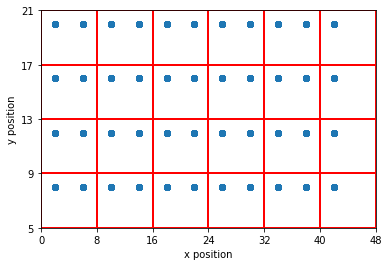

,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
0,2.0,8.0,-66,-92,-84,-84,-92,-93,-98,-96
1,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-96
2,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-100
3,2.0,8.0,-66,-94,-84,-84,-94,-80,-98,-100
4,2.0,8.0,-66,-94,-84,-84,-94,-74,-98,-100


In [173]:
import pandas as pd
import numpy as np

df = pd.read_csv("./IndoorFingerprint.csv")

import matplotlib.pyplot as plt
%matplotlib inline
X = df["X"]
Y = df["Y"]
plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

conditions = [
    ((df['X'] > 0.0) & (df['X'] <= 8.0)) & ((df['Y'] > 0.0) & (df['Y'] <= 9.0)),
     ((df['X'] > 8) &  (df['X'] <= 16) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 16) & (df['X'] <= 24) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 24) & (df['X'] <= 32) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 32) & (df['X'] <= 40) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     ((df['X'] > 40) & (df['X'] <= 48) ) & ((df['Y'] > 0) & (df['Y'] <= 9)),
     
     ((df['X'] > 0) & (df['X'] <= 8 )) &  ( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 8) & (df['X'] <= 16 )) & ( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 16) &( df['X'] <= 24) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 24) &( df['X'] <= 32) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 32) &( df['X'] <= 40) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     ((df['X'] > 40) &( df['X'] <= 48) ) &( (df['Y'] > 9 )& (df['Y'] <= 13)),
     
     ((df['X'] > 0 )& (df['X'] <= 8 )) &   ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 8 )& (df['X'] <= 16 )) &  ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 16) &( df['X'] <= 24) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 24) &( df['X'] <= 32) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 32) &( df['X'] <= 40) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     ((df['X'] > 40) &( df['X'] <= 48) ) & ((df['Y'] > 13 )& (df['Y'] <= 17)),
     
     ((df['X'] > 0 )&  (df['X'] <= 8 )) &  ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 8 )&  (df['X'] <= 16) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 16) & (df['X'] <= 24) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 24) & (df['X'] <= 32) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 32) & (df['X'] <= 40) ) & ((df['Y'] > 17) & (df['Y'] <= 21)),
     ((df['X'] > 40) & (df['X'] <= 48) ) & ((df['Y'] > 17) & (df['Y'] <= 21))]
     
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
#pd.get_dummies(df,prefix=['new_class'])
df.head()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje *x* y del eje *y*), el punto (2,20) está en la zona 19 (o en la primera zona del eje *x* y la cuarta zona del eje *y*). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "*x*" y 4 zonas para el eje "*y*", contando con un total de 24 clases (24 zonas en la malla).

> Deberá entrenar una red neuronal *feed forward* para la clasificación de las 24 posibles clases, con el objetivo de tener un desempeño (*accuracy*) mayor al 75%.
#### Importante
El conjunto de pruebas está **fijado** a través de los indices de posiciones del dataset, por lo que deberá leer estos indices y crear el conjunto de pruebas a partir de éstos.

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

mask_test = np.loadtxt('mask_test.csv',dtype="i")
df = pd.read_csv("./IndoorFingerprint.csv")

df['new_class'] = np.select(conditions, choices)
df = df.drop(['X','Y'], axis=1)

df_test = pd.DataFrame(df,index=mask_test)
df_train = pd.DataFrame(df.drop(df.index[mask_test]))
 
y_train = (pd.DataFrame(df_train['new_class']))
X_train = df_train.drop(['new_class'], axis=1)

y_test = (pd.DataFrame(df_test['new_class']))
X_test = df_test.drop(['new_class'], axis=1)

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)

scaler = StandardScaler().fit(X_train)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

y_train = pd.get_dummies(y_train,columns=["new_class"])
y_test = pd.get_dummies(y_test,columns=["new_class"])

print(X_test_scaled.shape,y_test.shape)
print(X_train_scaled.shape,y_train.shape)

(1980, 8) (1980, 24)
(4620, 8) (4620, 24)


In [219]:
neuronas_list = np.linspace(1,500,20,dtype=int)
neuronas_list

array([  1,  27,  53,  79, 106, 132, 158, 184, 211, 237, 263, 289, 316,
       342, 368, 394, 421, 447, 473, 500])

In [216]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import matplotlib.pyplot as plt

model = Sequential()
model.add(Dense(8, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(24, kernel_initializer='uniform',activation = "softmax"))
model.compile(optimizer=SGD(lr=0.01),loss='categorical_crossentropy')
hist = model.fit(X_train_scaled,y_train, epochs=300,verbose=0, validation_data=(X_test_scaled, y_test))
error = model.evaluate(np.asmatrix(X_train_scaled),np.asmatrix(y_train))

InternalError: GPU sync failed